# 3.6

手写识别为例，使用使用LabelSpreading模型做MNist数据集分类。

In [7]:
import numpy as np
from sklearn import datasets

digits = datasets.load_digits()
total = len(digits.data)
indices = np.arange(total)

aa = np.random.RandomState(2).shuffle(indices)

X = digits.data[indices]
y = digits.target[indices]


In [8]:
# 用于半监督学习的数据集

labeled_point = 40
y_train = np.copy(y)
y_train[labeled_point:] = -1 # -1是去标签，表示去除labeled_points 以后的标签

In [12]:
# 定义模型、训练、结果

# 标签传播算法
from sklearn.semi_supervised import LabelSpreading
# 评估分类模型性能
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Instanciate，gamma用于控制样本之间相似度的计算方式。gamma越大，表示样本之间的相似度衰减得越快，即只有距离很近的样本才会有较高的相似度；gamma越小，表示样本之间的相似度衰减得越慢，即距离较远的样本也会有较高的相似度。因此，gamma的选择会影响模型对于不同尺度下样本分布的敏感程度。
lp_model = LabelSpreading(gamma=0.25)

# Training
lp_model.fit(X,y_train)

# Predict results
# 从lp_model中获取预测结果，赋值给pred_labels。pred_labels是一个一维数组，表示所有样本的预测标签值。lp_model有一个属性叫做transduction_，它是一个一维数组，表示模型在训练过程中对所有样本进行标签传播后得到的结果。
pred_labels = lp_model.transduction_[labeled_point:]

# Get True labels
# 前面的已经有真实值了，所以才从labeled_point 开始
true_labels = y[labeled_point:]

# 查看模型分类结果报告
print(
    "Label Spreading model: %d labeled & %d unlabeled points (%d total)"
    % (labeled_point, total - labeled_point, total)
)
print(classification_report(true_labels, pred_labels))  # 打印性能指标
print(confusion_matrix(true_labels, pred_labels))  # 打印混淆矩阵，可以看出每个数字判断正确和错误的情况

Label Spreading model: 40 labeled & 1757 unlabeled points (1797 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       0.81      0.97      0.88       177
           2       0.98      0.93      0.95       175
           3       0.98      0.93      0.95       182
           4       0.97      0.98      0.98       173
           5       0.90      0.96      0.93       176
           6       0.99      1.00      1.00       173
           7       0.98      0.96      0.97       176
           8       0.92      0.80      0.86       173
           9       0.93      0.89      0.91       176

    accuracy                           0.94      1757
   macro avg       0.95      0.94      0.94      1757
weighted avg       0.95      0.94      0.94      1757

[[176   0   0   0   0   0   0   0   0   0]
 [  0 172   0   0   3   1   0   0   0   1]
 [  0  10 163   1   0   0   0   0   1   0]
 [  0   0   0 169   0   2   0   1   5   5

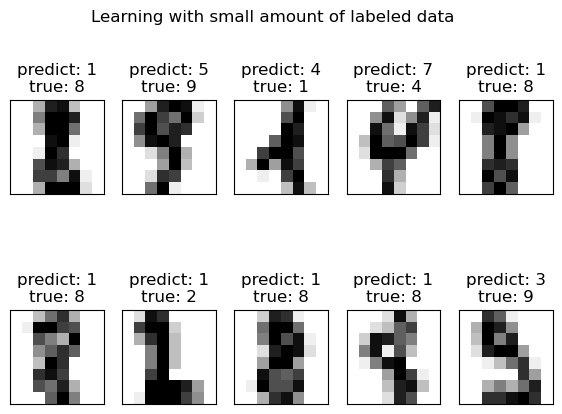

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

# 得到所有错误结果的索引
error_index =np.where(pred_labels-true_labels != 0)[0]

# Fig
f= plt.figure(figsize=(7,5))
f.suptitle("Learning with small amount of labeled data")
for i, index in enumerate(error_index[:10]):
    image = X[index + labeled_point].reshape(8,8) 
    sub = f.add_subplot(2, 5, i+1) # 2行5列
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title(
        "predict: %i\ntrue: %i" %(pred_labels[index], true_labels[index])
    )

半监督学习考虑了全部样本的分布，性能优于只有少量有标签样本的逻辑回归算法

In [16]:
# 上例中的40个带标签样本来训练一个一般的逻辑回归分类器，对剩余标签进行分类，可对比分类效果

from sklearn import ensemble

# instantiate
clf = ensemble.ExtraTreesClassifier()

# Train
clf = clf.fit(X[:labeled_point:], y_train[:labeled_point])

# Pred
pred = clf.predict(X[labeled_point:])

# Print Evaluate
print(classification_report(y[labeled_point:], pred))

# Print ConfusionMatrix
print(confusion_matrix(y[labeled_point:], pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93       176
           1       0.50      0.79      0.61       177
           2       0.90      0.26      0.40       175
           3       0.91      0.23      0.37       182
           4       0.46      0.98      0.63       173
           5       0.62      0.90      0.73       176
           6       0.78      0.98      0.87       173
           7       0.91      0.73      0.81       176
           8       1.00      0.08      0.15       173
           9       0.65      0.83      0.73       176

    accuracy                           0.66      1757
   macro avg       0.77      0.67      0.62      1757
weighted avg       0.77      0.66      0.62      1757

[[155   0   0   0  13   0   6   0   0   2]
 [  0 139   0   0  30   0   3   0   0   5]
 [  1  95  45   3  23   2   1   2   0   3]
 [  1  17   5  42   3  59   1   4   0  50]
 [  0   1   0   0 170   0   1   1   0   0]
 [  1   1   0   0   3 159 

可以发现，这时的有监督学习算法性能是原地于半监督学习方法的。

原因：训练样本数过少导致的过拟合

也告诉我们训练样本较少，且需要预测的样本在训练前已经获得时，可以考虑半监督学习方法